In [1]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install python-dotenv


Note: you may need to restart the kernel to use updated packages.


# 1. 데이터 수집

### 2024년 비트코인 시세 데이터
- Upbit에서 API를 활용

In [1]:
import requests
from datetime import datetime, timedelta

def fetch_upbit_daily_candles(market: str, from_date: str, to_date: str):
    url = "https://api.upbit.com/v1/candles/days"
    headers = {"accept": "application/json"}
    
    all_candles = []
    to = to_date

    while True:
        params = {
            "market": market,
            "count": 200,
            "to": to
        }
        response = requests.get(url, params=params, headers=headers)
        candles = response.json()

        # 오류 처리
        if not isinstance(candles, list):
            print("Error:", candles)
            break

        for candle in candles:
            candle_date = candle['candle_date_time_utc'][:10]
            if candle_date < from_date:
                return all_candles  # 종료 조건
            all_candles.append(candle)

        # 마지막 캔들의 이전 날짜로 to 갱신
        last_date = datetime.strptime(candles[-1]['candle_date_time_utc'], "%Y-%m-%dT%H:%M:%S")
        to = (last_date - timedelta(days=1)).strftime("%Y-%m-%dT%H:%M:%S")

        # 이미 충분히 가져왔을 경우
        if len(all_candles) >= 365:
            break

    return all_candles


In [2]:
import pandas as pd

# 2024년 비트코인 일봉 데이터 요청
market = "KRW-BTC"
from_date = "2024-01-01"
to_date = "2024-12-31T00:00:00"

btc_2024_data = fetch_upbit_daily_candles(market, from_date, to_date)

# 결과 출력
btc_df = pd.DataFrame(btc_2024_data)
display(btc_df)

,market,candle_date_time_utc,candle_date_time_kst,opening_price,high_price,low_price,trade_price,timestamp,candle_acc_trade_price,candle_acc_trade_volume,prev_closing_price,change_price,change_rate
0,KRW-BTC,2024-12-30T00:00:00,2024-12-30T09:00:00,139831000.0,140680000.0,135971000.0,137892000.0,1735603199382,5.208487e+11,3767.669781,139735000.0,-1843000.0,-0.013189
1,KRW-BTC,2024-12-29T00:00:00,2024-12-29T09:00:00,142306000.0,142380000.0,138600000.0,139735000.0,1735516799943,3.065153e+11,2180.406377,142302000.0,-2567000.0,-0.018039
2,KRW-BTC,2024-12-28T00:00:00,2024-12-28T09:00:00,142107000.0,143000000.0,141487000.0,142302000.0,1735430399613,1.863486e+11,1311.563873,142111000.0,191000.0,0.001344
3,KRW-BTC,2024-12-27T00:00:00,2024-12-27T09:00:00,144016000.0,146117000.0,141466000.0,142111000.0,1735343999444,4.646690e+11,3231.263284,144076000.0,-1965000.0,-0.013639
4,KRW-BTC,2024-12-26T00:00:00,2024-12-26T09:00:00,148216000.0,149000000.0,143175000.0,144076000.0,1735257600013,4.991777e+11,3432.784430,148081000.0,-4005000.0,-0.027046
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,KRW-BTC,2024-01-05T00:00:00,2024-01-05T09:00:00,59477000.0,59695000.0,57577000.0,59351000.0,1704499198889,2.843524e+11,4822.389677,59477000.0,-126000.0,-0.002118
360,KRW-BTC,2024-01-04T00:00:00,2024-01-04T09:00:00,58581000.0,60162000.0,57319000.0,59477000.0,1704412798132,3.660256e+11,6254.537687,58581000.0,896000.0,0.015295
361,KRW-BTC,2024-01-03T00:00:00,2024-01-03T09:00:00,60205000.0,60799000.0,54346000.0,58581000.0,1704326399884,9.458412e+11,16310.306926,60206000.0,-1625000.0,-0.026991
362,KRW-BTC,2024-01-02T00:00:00,2024-01-02T09:00:00,58839000.0,60997000.0,58814000.0,60206000.0,1704239999808,4.950388e+11,8221.198684,58839000.0,1367000.0,0.023233


In [3]:
btc_df.to_csv("btc_2024.csv", index=False, encoding="utf-8-sig")

### 2024년 날씨 데이터
- 기상청(KMA) API 활용

In [6]:
import pandas as pd
import requests
from io import StringIO
from datetime import datetime, timedelta
import time
import os

def fetch_weather_for_date(date: datetime, station: str = "108") -> dict:
    url = "https://apihub.kma.go.kr/api/typ01/url/kma_sfctm2.php"
    AUTH_KEY = os.getenv("KMA_API_KEY")

    tm = date.strftime("%Y%m%d0900")  # 오전 9시 기준 관측

    params = {
        "tm": tm,
        "stn": station,
        "authKey": AUTH_KEY
    }

    try:
        response = requests.get(url, params=params, timeout=15)
        lines = response.text.split("\n")

        header_line = next(line for line in lines if line.startswith("# YYMMDD"))
        data_line = next(line for line in lines if not line.startswith("#") and line.strip())

        columns = header_line[1:].strip().split()
        values = data_line.strip().split()

        return dict(zip(columns, values))

    except Exception as e:
        print(f"[{tm}] 요청 실패: {e}")
        time.sleep(2)  # 잠시 쉬었다가
        return fetch_weather_for_date(date)  # 재시도 (최대 1회 등 제한 가능)

def fetch_weather_2024():
    start_date = datetime(2024, 1, 1)
    end_date = datetime(2024, 12, 31)
    current = start_date

    results = []

    while current <= end_date:
        weather_data = fetch_weather_for_date(current)
        if weather_data:
            results.append(weather_data)
        current += timedelta(days=1)

    df = pd.DataFrame(results)
    return df

In [ ]:
# 실행
weather_2024_df = fetch_weather_2024()

[202401010900] 요청 실패: HTTPSConnectionPool(host='apihub.kma.go.kr', port=443): Read timed out. (read timeout=15)


KeyboardInterrupt: 

In [ ]:
display(weather_2024_df)

In [ ]:
weather_2024_df.to_csv("weather_2024_seoul.csv", index=False, encoding="utf-8-sig")

In [ ]:
# 요청 실패 데이터만 따로 가져오기
# failed_dates = [
#     "20240101", "20240102",
#     "20240311", "20241003", "20241004"
# ]

# results = []
# for date_str in failed_dates:
#       dt = datetime.strptime(date_str, "%Y%m%d")
#       data = fetch_weather_for_date(dt)
#       if data:
#           results.append(data)
  
# retry_df = pd.DataFrame(results)

# display(retry_df)

# 2. 데이터 정제 및 전처리

1. 필요한 컬럼만 추출 및 리네이밍
2. `date` 기준 병합
3. 거래금액당 평균 가격 컬럼 생성

In [7]:
import pandas as pd

weather_df = pd.read_csv("weather_2024_seoul.csv", encoding="utf-8-sig")
btc_df = pd.read_csv("btc_2024.csv", encoding="utf-8-sig")

In [8]:
keep_columns = [
    "YYMMDDHHMI",  # 날짜 기준 merge용
    "TA",          # 기온
    "HM",          # 습도
    "WS",          # 풍속
    "SS",          # 일조시간
    "WW"           # 날씨코드 (흐림, 맑음 등)
]

# weather_2024_df: 기존 수집된 전체 날씨 데이터
filtered_weather = weather_df[keep_columns].copy()
filtered_weather.rename(columns={
    "YYMMDDHHMI": "datetime",
    "TA": "temperature",
    "HM": "humidity",
    "WS": "wind_speed",
    "RN_DAY": "rainfall",
    "SS": "sunshine_hours",
    "WW": "weather_code"
}, inplace=True)

# datetime 타입으로 변환
filtered_weather["date"] = pd.to_datetime(filtered_weather["datetime"], format="%Y%m%d%H%M")
filtered_weather.drop(columns=["datetime"], inplace=True)

# 결과 확인
filtered_weather.head(2)

,temperature,humidity,wind_speed,sunshine_hours,weather_code,date
0,2.1,85.0,2.0,0.0,1901,2024-01-03 09:00:00
1,-1.8,84.0,2.6,0.0,19,2024-01-04 09:00:00


In [9]:
keep_columns = [
    "candle_date_time_kst",     # 캔들 기준 시각(KST 기준)
    "opening_price",            # 시가  
    "high_price",               # 고가
    "low_price",                # 저가  
    "trade_price",              # 종가
    "candle_acc_trade_volume",  # 누적 거래량
    "candle_acc_trade_price"    # 누적 거래 금액
]

# 필터링
filtered_btc = btc_df[keep_columns].copy()
filtered_btc["date"] = pd.to_datetime(filtered_btc["candle_date_time_kst"])

filtered_btc.head(2)

,candle_date_time_kst,opening_price,high_price,low_price,trade_price,candle_acc_trade_volume,candle_acc_trade_price,date
0,2024-12-30T09:00:00,139831000.0,140680000.0,135971000.0,137892000.0,3767.669781,5.208487e+11,2024-12-30 09:00:00
1,2024-12-29T09:00:00,142306000.0,142380000.0,138600000.0,139735000.0,2180.406377,3.065153e+11,2024-12-29 09:00:00


In [10]:
filtered_weather.sort_values(by="date", inplace=True)
filtered_btc.sort_values(by="date", inplace=True)

display(filtered_weather.head())
display(filtered_btc.head())

,temperature,humidity,wind_speed,sunshine_hours,weather_code,date
0,2.1,85.0,2.0,0.0,1901,2024-01-03 09:00:00
1,-1.8,84.0,2.6,0.0,19,2024-01-04 09:00:00
2,5.1,88.0,0.8,0.0,19,2024-01-05 09:00:00
3,-2.0,63.0,1.9,1.0,-,2024-01-06 09:00:00
4,-4.6,57.0,3.1,0.9,-,2024-01-07 09:00:00


,candle_date_time_kst,opening_price,high_price,low_price,trade_price,candle_acc_trade_volume,candle_acc_trade_price,date
363,2024-01-01T09:00:00,57045000.0,58847000.0,57045000.0,58839000.0,3165.320929,1.824912e+11,2024-01-01 09:00:00
362,2024-01-02T09:00:00,58839000.0,60997000.0,58814000.0,60206000.0,8221.198684,4.950388e+11,2024-01-02 09:00:00
361,2024-01-03T09:00:00,60205000.0,60799000.0,54346000.0,58581000.0,16310.306926,9.458412e+11,2024-01-03 09:00:00
360,2024-01-04T09:00:00,58581000.0,60162000.0,57319000.0,59477000.0,6254.537687,3.660256e+11,2024-01-04 09:00:00
359,2024-01-05T09:00:00,59477000.0,59695000.0,57577000.0,59351000.0,4822.389677,2.843524e+11,2024-01-05 09:00:00


In [11]:
filtered_btc["avg_trade_price_per_btc"] = (
    filtered_btc["candle_acc_trade_price"] / filtered_btc["candle_acc_trade_volume"]
)

# 3. 탐색적 데이터 분석 (EDA)
1. 상관계수 분석 (전체) : pairplot, heatmap
2. 시계열 그래프 (온도, 거래량, 가격 등) : 추세 비교
3. 연말/비연말 시즌 별 분석

In [12]:
filtered_btc.head(2)

,candle_date_time_kst,opening_price,high_price,low_price,trade_price,candle_acc_trade_volume,candle_acc_trade_price,date,avg_trade_price_per_btc
363,2024-01-01T09:00:00,57045000.0,58847000.0,57045000.0,58839000.0,3165.320929,1.824912e+11,2024-01-01 09:00:00,5.765331e+07
362,2024-01-02T09:00:00,58839000.0,60997000.0,58814000.0,60206000.0,8221.198684,4.950388e+11,2024-01-02 09:00:00,6.021492e+07


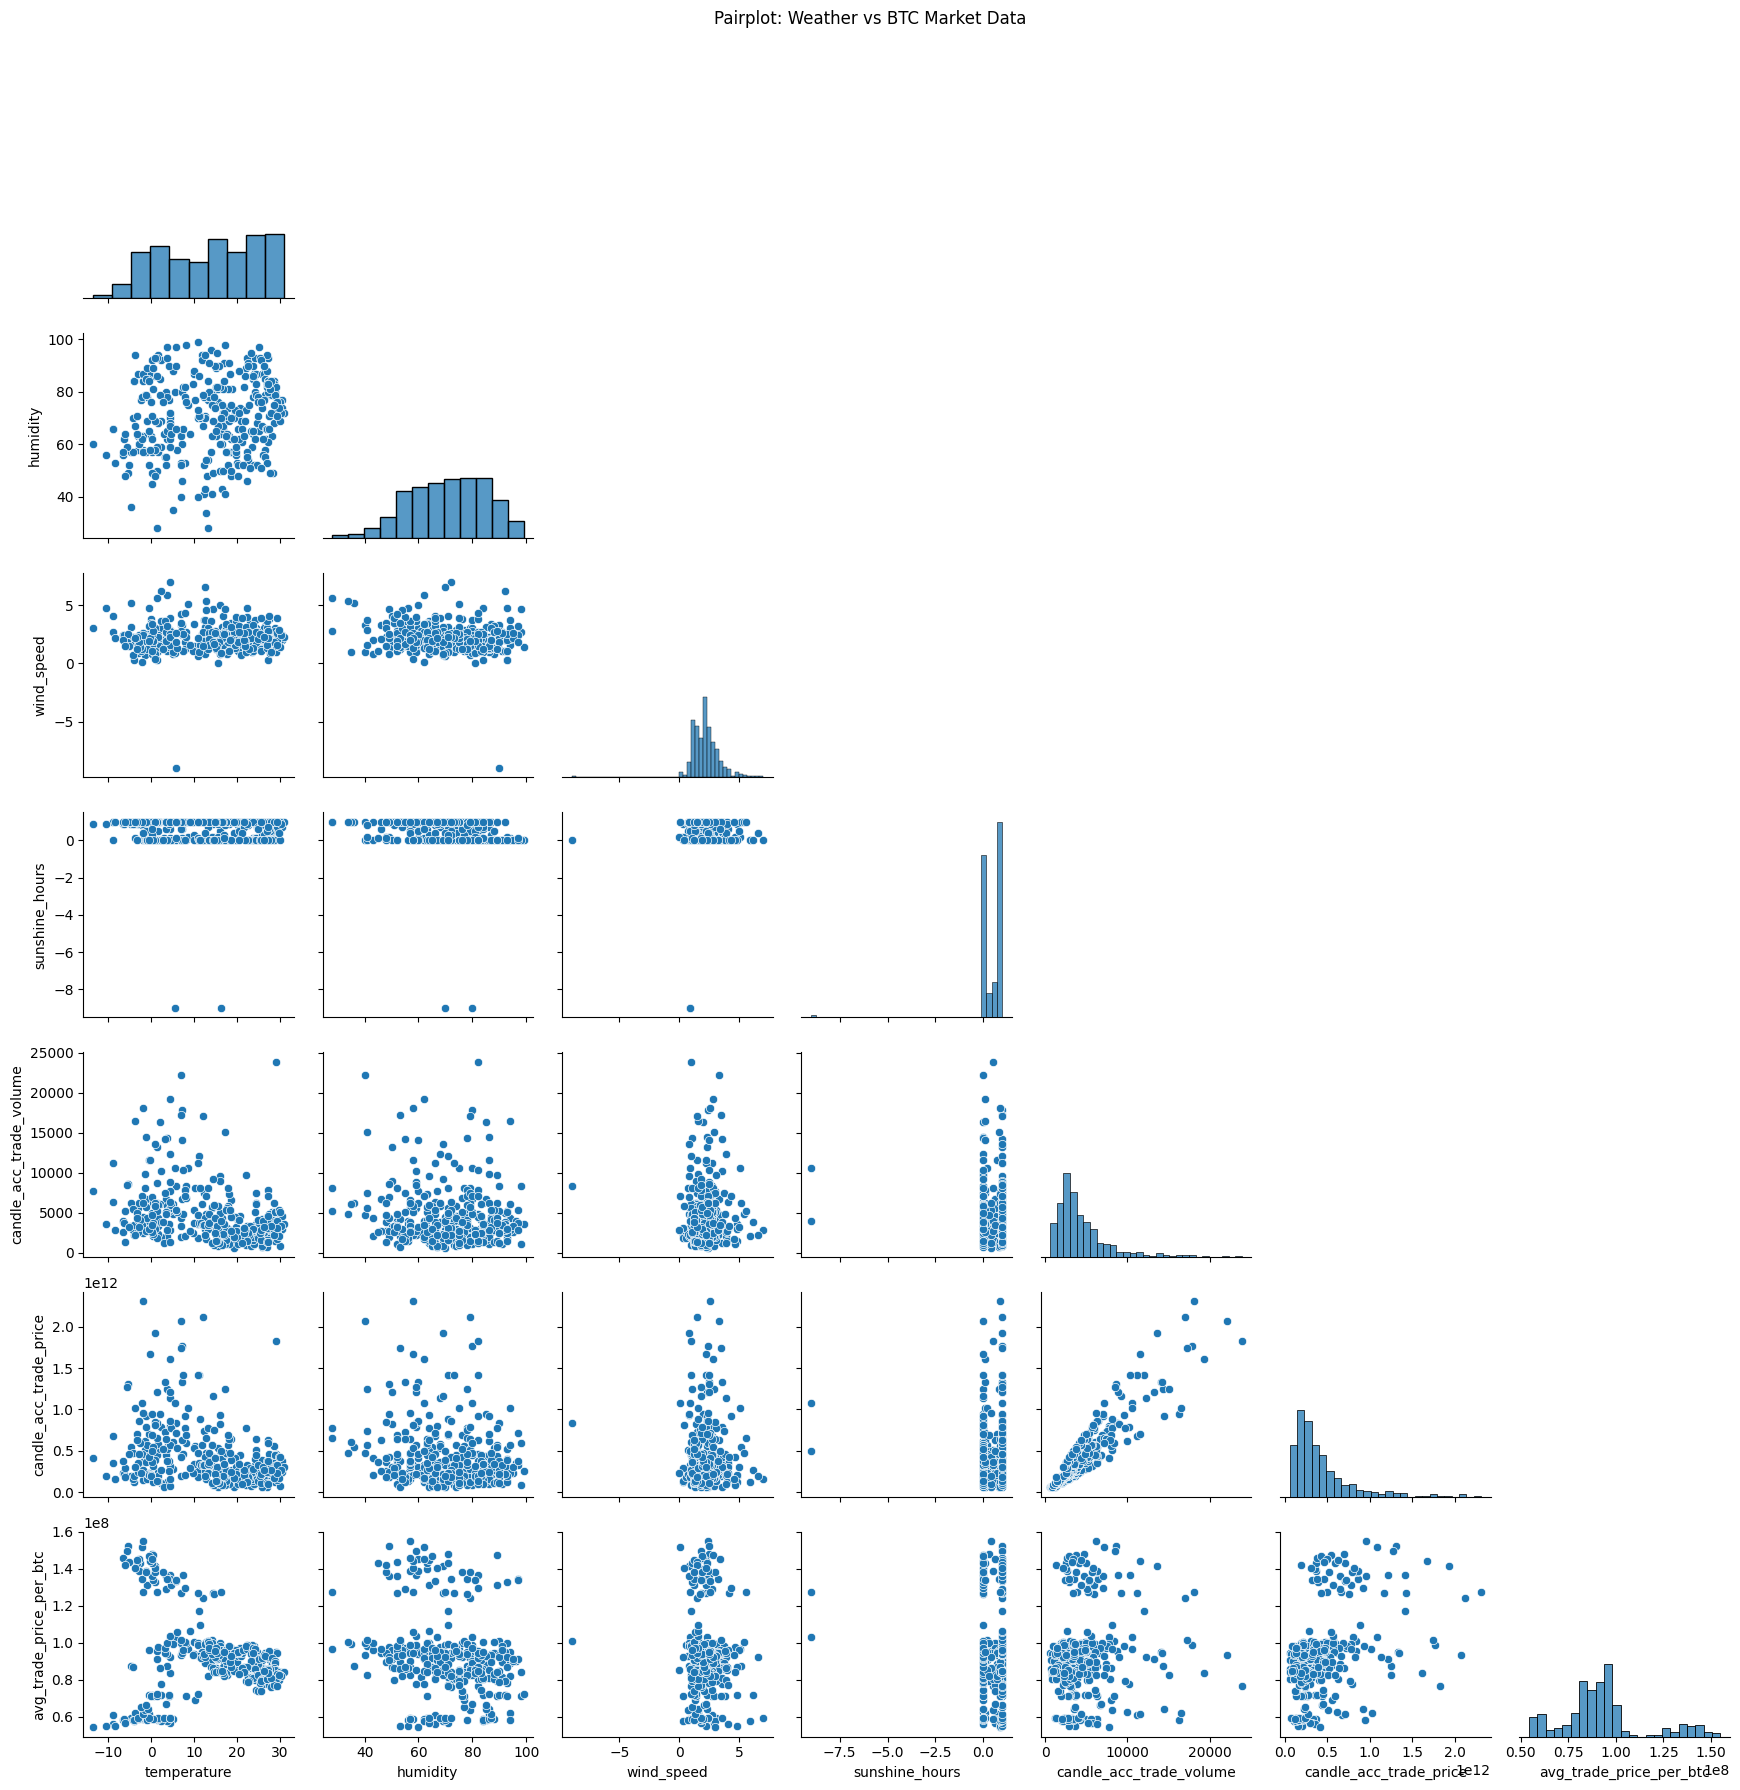

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 상관 분석에 사용할 컬럼 정의
weather_cols = ["temperature", "humidity", "wind_speed", "sunshine_hours"]
btc_cols = ["candle_acc_trade_volume", "candle_acc_trade_price", "avg_trade_price_per_btc"]

# 공통 날짜 기준 merge
merged_df = pd.merge(
    filtered_weather[["date"] + weather_cols],
    filtered_btc[["date"] + btc_cols],
    on="date", how="inner"
)

# pairplot 시각화
sns.pairplot(merged_df[weather_cols + btc_cols], corner=True)
plt.suptitle("Pairplot: Weather vs BTC Market Data", y=1.02)
plt.tight_layout()
plt.show()


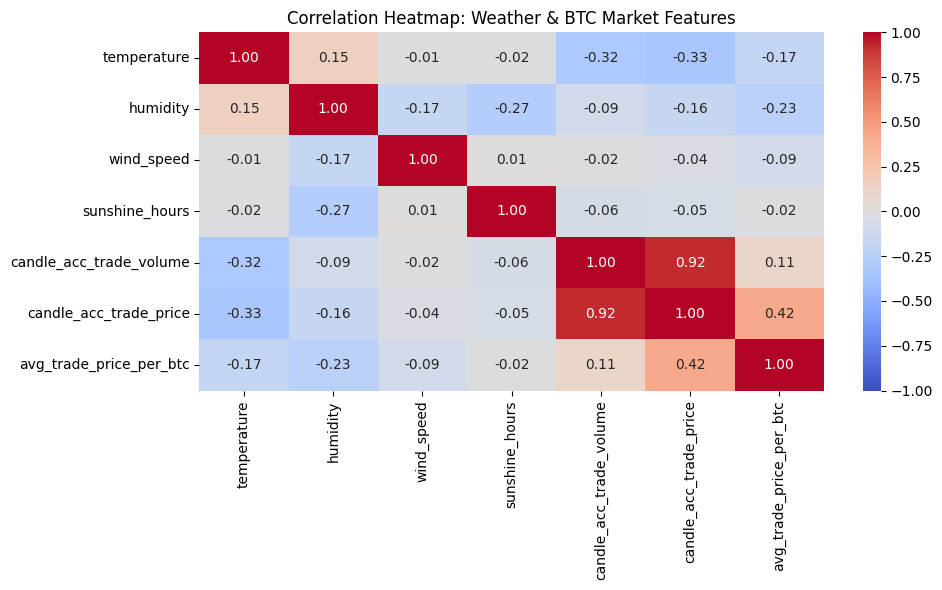

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
correlation_matrix = merged_df[weather_cols + btc_cols].corr()

# 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap: Weather & BTC Market Features")
plt.tight_layout()
plt.show()


## 칼럼 별 상관관계에 대해 데이터 중간 분석 내용

- `candle_acc_trade_price`와 `avg_trade_price_per_btc` 사이의 상관계수는 **0.42**로,  
  **거래금액이 증가할수록 비트코인 평균 거래 가격도 함께 오르는 경향**이 나타난다.
- 한편, `temperature`는  
  - `candle_acc_trade_volume`,  
  - `candle_acc_trade_price`,  
  - `avg_trade_price_per_btc`  
  모두와 **음의 상관관계**를 보인다.  

👉 즉, **날씨가 추울수록 비트코인 거래량, 금액, 가격이 증가하는 경향**이 존재한다.


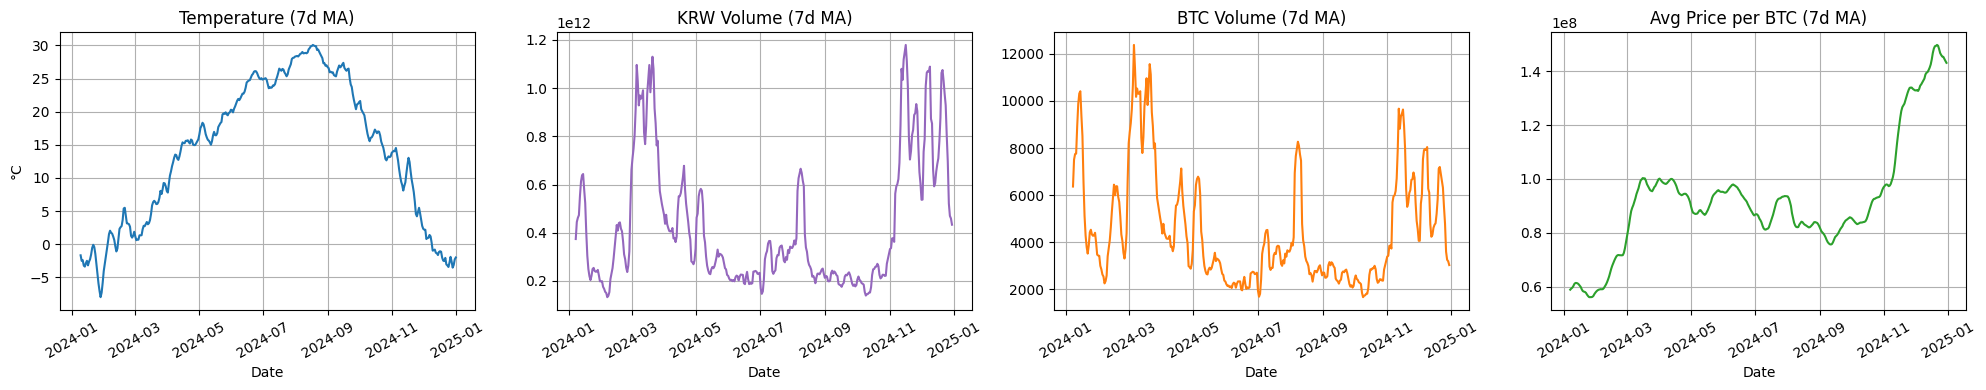

In [15]:
import matplotlib.pyplot as plt

# 7일 이동 평균 계산
filtered_weather['temperature_ma7'] = filtered_weather['temperature'].rolling(7).mean()
filtered_weather['humidity_ma7'] = filtered_weather['humidity'].rolling(7).mean()
filtered_btc['average_btc_ma7'] = filtered_btc['avg_trade_price_per_btc'].rolling(7).mean()
filtered_btc['volume_btc_ma7'] = filtered_btc['candle_acc_trade_volume'].rolling(7).mean()
filtered_btc['average_krw_ma7'] = filtered_btc['candle_acc_trade_price'].rolling(7).mean()

# 그래프 전체 그리기: 1행 4열
fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharex=True)

# 그래프 1: 온도
axes[0].plot(filtered_weather['date'], filtered_weather['temperature_ma7'], color='tab:blue')
axes[0].set_title("Temperature (7d MA)")
axes[0].set_ylabel("°C")
axes[0].grid(True)

# 그래프 2: KRW 거래 금액
axes[1].plot(filtered_btc['date'], filtered_btc['average_krw_ma7'], color='tab:purple')
axes[1].set_title("KRW Volume (7d MA)")
axes[1].grid(True)

# 그래프 3: BTC 거래량
axes[2].plot(filtered_btc['date'], filtered_btc['volume_btc_ma7'], color='tab:orange')
axes[2].set_title("BTC Volume (7d MA)")
axes[2].grid(True)

# 그래프 4: 평균 BTC 가격
axes[3].plot(filtered_btc['date'], filtered_btc['average_btc_ma7'], color='tab:green')
axes[3].set_title("Avg Price per BTC (7d MA)")
axes[3].grid(True)

# 공통 X축 레이블
for ax in axes:
    ax.set_xlabel("Date")
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


In [16]:
import pandas as pd

# 연말연시 구간: 11월, 12월, 1월
end_of_year = filtered_btc[filtered_btc['date'].dt.month.isin([11, 12, 1])]

# 비연말 구간: 2월 ~ 10월
rest_of_year = filtered_btc[filtered_btc['date'].dt.month.isin(range(2, 11))]

# 상관계수 계산
corr_end_of_year = end_of_year[['candle_acc_trade_price', 'avg_trade_price_per_btc']].corr().iloc[0, 1]
corr_rest_of_year = rest_of_year[['candle_acc_trade_price', 'avg_trade_price_per_btc']].corr().iloc[0, 1]

# 출력
print(f"📈 연말연시 상관계수 (11~1월): {corr_end_of_year:.3f}")
print(f"📉 비연말 상관계수 (2~10월): {corr_rest_of_year:.3f}")


📈 연말연시 상관계수 (11~1월): 0.443
📉 비연말 상관계수 (2~10월): 0.217


# 인사이트 정리
1. **연말연시는 수요 집중 시기**
  - 상관계수 0.443 <br/>
  → 11월~1월 사이, 비트코인을 구매하려는 수요가 집중되면서  
  **가격 상승으로 이어졌을 가능성**이 있다.
  투자 심리와 구매 수요가 가격 형성에 영향을 미쳤을 가능성이 높음.

2. **기온과 온라인 투자 행동**  
   → 추운 날씨가 외부 활동을 줄이고 **온라인 활동 및 자산 투자 집중**을 유도했을 수 있다.  
   특히 연말에는 **연초 기대감, 보너스 수령, 포트폴리오 조정 등**이 투자 심리에 영향을 줄 수 있다.

3. **비트코인의 계절성 가능성**  
   → 이 패턴은 비트코인이 **간접적인 계절성(Seasonality)** 을 가질 수 있다는 신호일 수 있다.  
   특정 계절 또는 시기(연말연시)에 **거래량과 가격이 함께 오르는 경향**이 반복될 수 있다.

기온과 시기(연말연시)는 비트코인 거래 활동에 일정한 영향을 미칠 수 있으며,  
이는 **단순한 가격 흐름 이상의 투자자 행동 심리와 맞물려 있는 복합적 현상**으로 해석할 수 있다.